<a href="https://colab.research.google.com/github/aymanish/PADL-Q2-Automated-Regression-Modelling/blob/main/Q2_padl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Q2**

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Binarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer






# Load the dataset
data_path = '/content/PADL-Q2-train.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
print(data.head())

# Generate descriptive statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Explore the unique values of 'w' to identify if it is categorical
print(data['w'].unique())


         x       y       z    w     out
0  66.4774  1.6495  0.7613  0.1 -0.0209
1  15.1422  2.2292  0.0050  0.1  0.1281
2  87.9859  2.1449  0.2217  0.1  0.1289
3  79.4979  2.0901  0.0396  0.1  0.1442
4  36.5181  2.0992  0.2040  0.0 -0.0131
                x          y          z          w        out
count   80.000000  80.000000  80.000000  80.000000  80.000000
mean    53.966259   2.003534   0.462200   0.043750  -0.008074
std     29.799416   0.200296   0.280881   0.049921   0.125383
min      3.962600   1.649500   0.005000   0.000000  -0.313900
25%     30.066050   1.847500   0.218050   0.000000  -0.089100
50%     53.163800   2.025150   0.462350   0.000000  -0.018100
75%     83.108325   2.147900   0.695225   0.100000   0.068275
max    100.068100   2.454000   0.975900   0.100000   0.362700
x      0
y      0
z      0
w      0
out    0
dtype: int64
[0.1 0. ]


Part A:

The data covers a range of values, with variable x showing a wide spread (from ~4 to 100), while w appears as a potential categorical variable with two distinct values (0 and 0.1).

Missing Values:

No missing values detected across all variables.


Categorical Unique values of w: [0.1, 0.0]
w has only two unique values, suggesting it might be a binary categorical variable, which can significantly impact our encoding and modeling decisions.



---

Encoding 'w':

Since 'w' appears to be a binary categorical variable, we've encode it using one-hot encoding. This involves converting 'w' into a format that can be effectively utilized by regression models.

We also want to plot histograms and scatter plots for the continuous variables (x, y, z) against out to understand their distributions and relationships before any transformations.

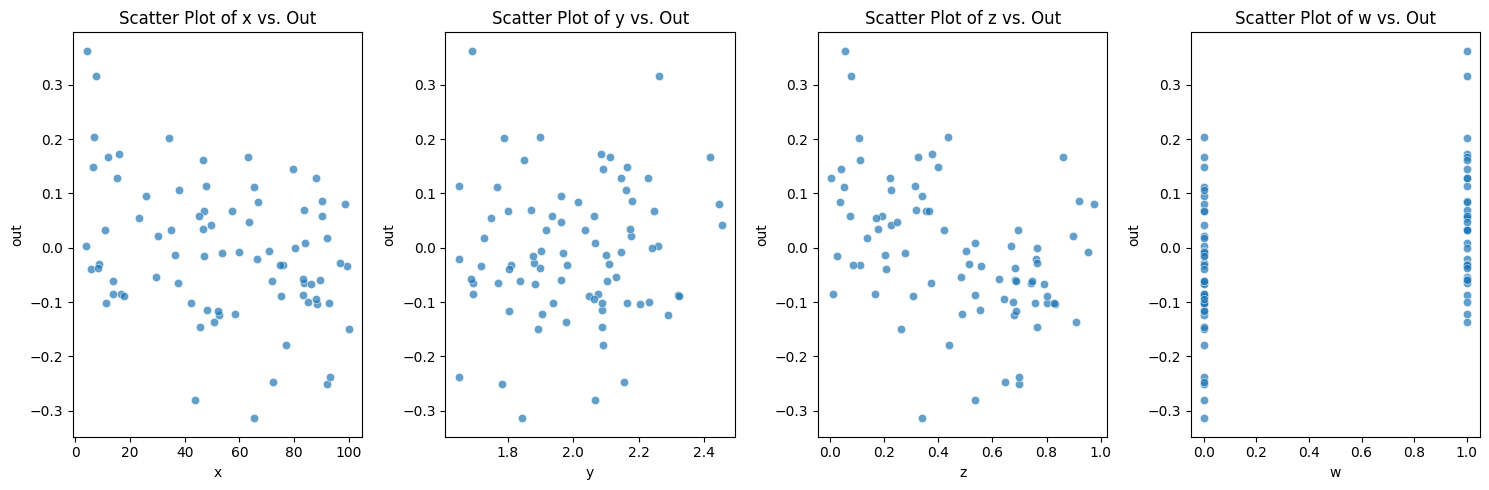

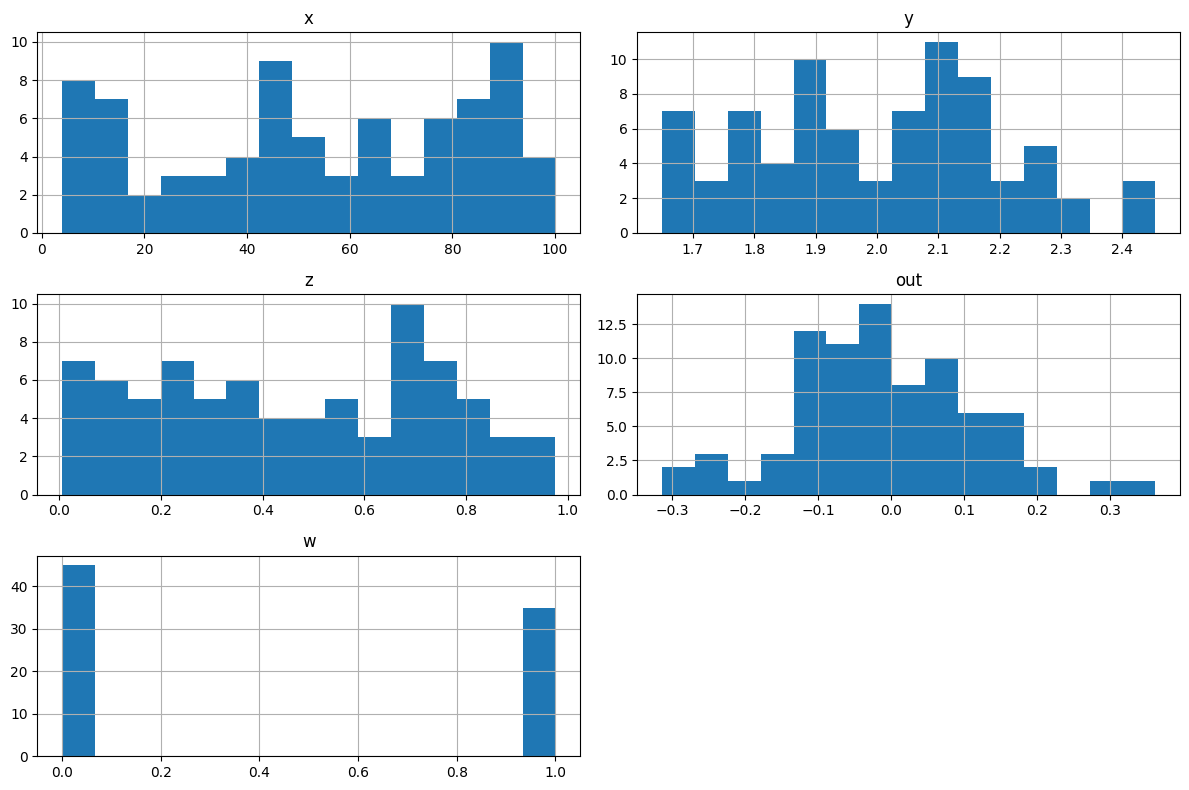

In [ ]:


# One-hot encoding of 'w'
encoder = Binarizer()
w_encoded = encoder.fit_transform(data[['w']])
#encoded_feature_names = encoder.get_feature_names(['w'])
data_encoded = pd.DataFrame(w_encoded, columns=['w'])

# Merge the encoded features back to the original dataframe
data_encoded = pd.concat([data.drop('w', axis=1), data_encoded], axis=1)

# Show the updated DataFrame with encoded features
print(data_encoded.head())

# Function to create initial plots
def initial_plots(df):
    features = ['x', 'y', 'z', 'w']
    fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15, 5))

    for i, feature in enumerate(features):
        sns.scatterplot(x=df[feature], y=df['out'], ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Scatter Plot of {feature} vs. Out')

    plt.tight_layout()
    plt.show()

    # Histograms for all features
    df.hist(figsize=(12, 8), bins=15)
    plt.tight_layout()
    plt.show()

# Execute the function to plot the data
initial_plots(data_encoded)

The scatter plots and histograms have been generated, providing insights into the relationships between each feature and the output variable, as well as the distribution of the features, including the newly encoded w_0.0 and w_0.1. Here's what we can interpret from the visuals:

Scatter Plots:
Continuous Features (x, y, z) vs. out: The scatter plots indicate varying degrees of relationships between these features and the output. There are no clear linear patterns, suggesting potential nonlinear relationships or the need for more complex modeling approaches like polynomial regression or interaction terms.

Histograms:
Distribution of Features: The histograms reveal how each feature, including the binary encoded w, is distributed across the dataset. Notably, the encoding shows clear binary distributions for w_0.0 and w_0.1, which is expected.

In [ ]:
# Assuming 'x', 'y', 'z', and 'w' are your features, and 'out' is your target.
feature_columns = ['x', 'y', 'z', 'w']
target_column = 'out'

# Splitting the dataset into features (X) and target (Y)
X = data_encoded[feature_columns]
Y = data_encoded[target_column]



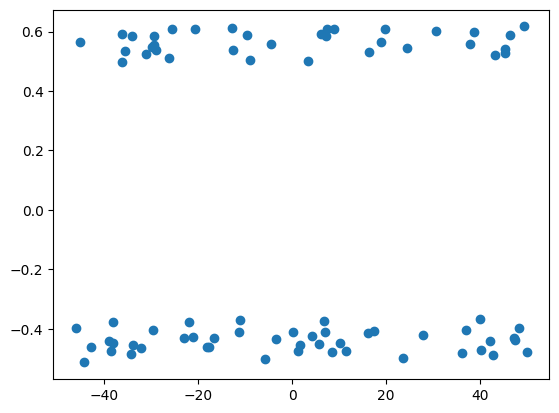

In [ ]:
np.random.seed(123)
# No preprocessing:
pca = PCA(2)
low_d = pca.fit_transform(X)
plt.scatter(low_d[:,0], low_d[:,1])



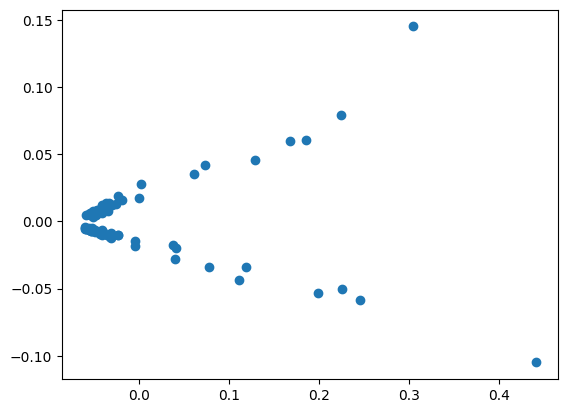

In [ ]:
# normalize
Xn = normalize(X)
pca = PCA(2)
low_d = pca.fit_transform(Xn)
plt.scatter(low_d[:,0], low_d[:,1])


The fact that the binary variable W was on a different scale from the others has created a clustering effect on one end where one might not necessarily exist. This is because the SVD considers it more than other variables as it contributes more to squared error. This may be solved by scaling the dataset:


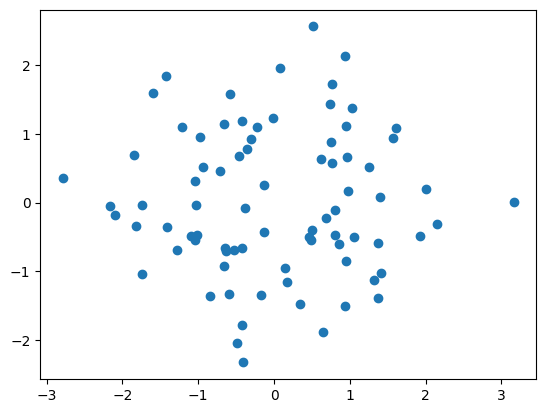

In [ ]:

# Scale
Xs = scale(X)
low_d = pca.fit_transform(Xs)
plt.scatter(low_d[:,0], low_d[:,1])

Hence, We finally see (correctly) that the data are completely random noise. As normalising might contribute more to the squared error, we only consider scaling our data but not normalising.


In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Part A / B:

We first tried evaluating a Linear regression without regularisation across differenet polynomial degrees. There is alwasy a chance that the actual data which is bigger than our small dataset could have a very simple relationship.

Degree: 1, Train R²: 0.4614497063275764, Test R²: -0.4802532598443203
Degree: 2, Train R²: 0.5263107638035459, Test R²: -0.07692665429337553
Degree: 3, Train R²: -0.14532252211888208, Test R²: -1.2622061205726398
Degree: 4, Train R²: 0.9618396787679654, Test R²: -54.55674648286946
Degree: 5, Train R²: 1.0, Test R²: -18.575750257071366


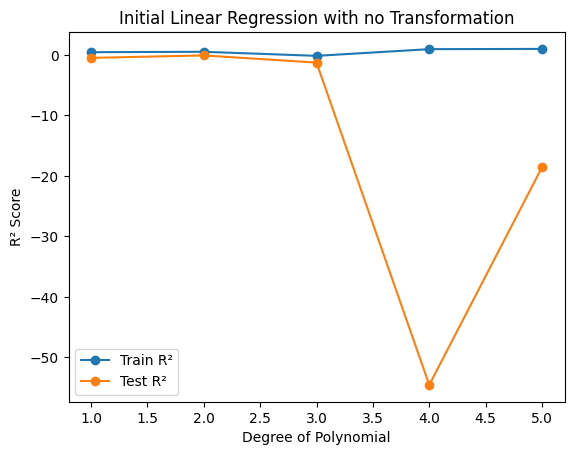

In [ ]:
# Evaluate initial linear regression models with different polynomial degrees
degrees = [1, 2, 3, 4, 5]
initial_results = {}

for degree in degrees:
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])

    pipeline.fit(X_train, Y_train)
    Y_pred_train = pipeline.predict(X_train)
    Y_pred_test = pipeline.predict(X_test)

    train_r2 = r2_score(Y_train, Y_pred_train)
    test_r2 = r2_score(Y_test, Y_pred_test)

    initial_results[degree] = {'train_r2': train_r2, 'test_r2': test_r2}
    print(f"Degree: {degree}, Train R²: {train_r2}, Test R²: {test_r2}")

# Plot the initial results
degrees = list(initial_results.keys())
train_r2_scores = [initial_results[deg]['train_r2'] for deg in degrees]
test_r2_scores = [initial_results[deg]['test_r2'] for deg in degrees]

plt.plot(degrees, train_r2_scores, marker='o', label='Train R²')
plt.plot(degrees, test_r2_scores, marker='o', label='Test R²')
plt.xlabel('Degree of Polynomial')
plt.ylabel('R² Score')
plt.title('Initial Linear Regression with no Transformation')
plt.legend()
plt.show()

From the plot above we can see that the R2 score for both testing and training is low and is indicative for small datasets. The best returns were from Degree 2 as we had the smallest generalisation gap between train and test at 0.52 and -0.08 R2. Hence we nominate that as one of our models.


---



To address potential overfitting and ensure our model generalizes well to unseen data, we explored both Ridge and Lasso regression techniques. These methods add a regularization term to the cost function, controlled by the alpha (α) parameter. Given our small dataset (80 data points), regularization is crucial to avoid overfitting.


---


Effects of Hyperparameters: Alpha and Polynomial Degree
Ridge Regression:

Low α: The model fits the training data closely, capturing more variance, which can lead to overfitting.
High α: Shrinks the coefficients, simplifying the model and potentially improving generalization by reducing overfitting. However, too high α can lead to underfitting, making the model too simple to capture underlying data patterns.
Lasso Regression:

Low α: Similar to Ridge, it allows the model to fit the training data more closely, risking overfitting.
High α: Encourages sparsity in the coefficients, meaning some coefficients become exactly zero. This is useful for feature selection, as it removes less important features. However, too high α can also lead to underfitting if too many features are removed.
Polynomial Degree:
Higher polynomial degrees can model more complex relationships in the data. However, without regularization, high-degree polynomials can lead to overfitting. Thus, finding the right balance between polynomial degree and regularization strength is crucial.


---


Cross-Validation and Evaluation Metrics
Cross-Validation (CV):

Purpose: To evaluate the model's performance on different subsets of the training data to ensure it generalizes well.
Procedure: The data is split into k folds. Given our small dataset, we chose 5 folds to maintain a balance between bias and variance. Each fold acts as a validation set once while the remaining folds are used for training.
Metrics: During cross-validation, we measure:
Training R² (CV): How well the model fits the training data for each fold.
Validation/Testing R² (CV): How well the model predicts the validation data for each fold.
Result: The mean and standard deviation of these R² scores are reported.


---


Final Evaluation on Test Set:

Purpose: To evaluate the model's performance on completely unseen data.
Procedure: The best model from cross-validation is retrained on the entire training set and then evaluated on the test set.
Metrics: The final R² score, Mean Squared Error (MSE), and Residual Sum of Squares (RSS) on the test set.
Implementation Using Bayesian Optimization
We used Bayesian optimization for hyperparameter tuning due to its efficiency in searching through complex parameter spaces. This method also provides a clear visualization of the effects of different hyperparameters.


---

Code:

Using the BayesSearchCV function, we performed Bayesian optimization with 50 iterations and 5-fold cross-validation. This helped us identify the best combinations of α and polynomial degrees for both Lasso and Ridge regression models. During cross-validation, we calculated the mean and standard deviation of the R² scores for the training data. We then evaluated the best models on the test set to obtain the final test R² scores.

For Lasso regression, the best model parameters and their corresponding R² scores were identified. Similarly, the best Ridge regression model parameters were determined. Additionally, we visualized the effects of different α values and polynomial degrees on the R² scores using color maps. This provided a comprehensive view of how the models performed across the parameter space.

Finally, we calculated additional metrics such as Mean Squared Error (MSE) and Residual Sum of Squares (RSS) for the test set to further evaluate the model performance. This approach ensures that we select models that not only perform well on the training data but also generalize effectively to unseen data, which is critical given our small dataset.

Lasso - Best params: OrderedDict([('poly__degree', 4), ('regressor__alpha', 0.003823615086382278)]), Train R² Mean: 0.29042470188998004, Train R² Std: 0.0, Test R²: -0.25180878534508766
Ridge - Best params: OrderedDict([('poly__degree', 4), ('regressor__alpha', 14.384768718356632)]), Train R² Mean: 0.2967908065866328, Train R² Std: 0.0, Test R²: -0.3615900476256013


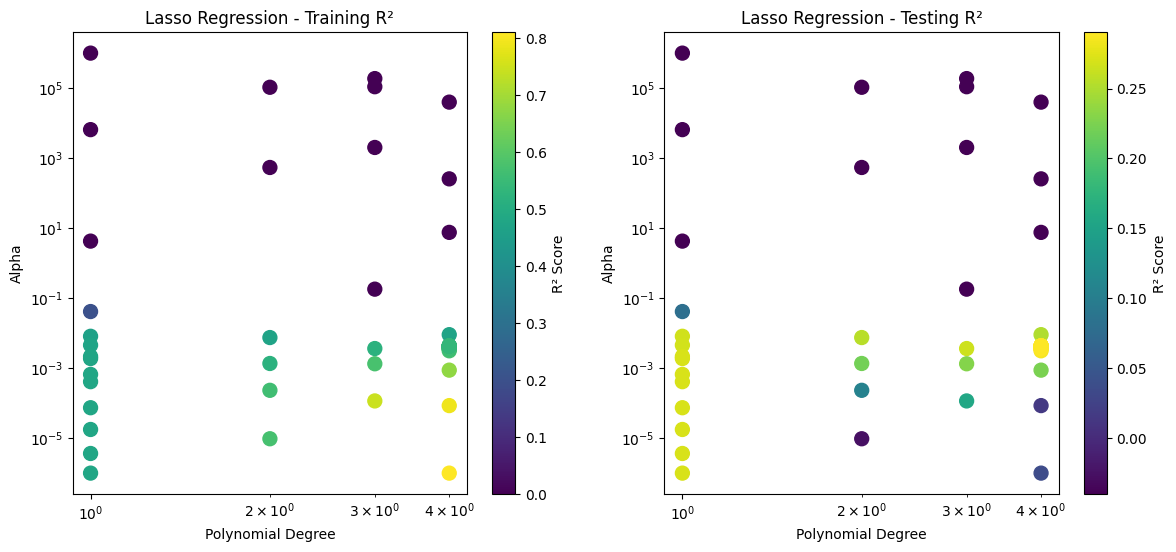

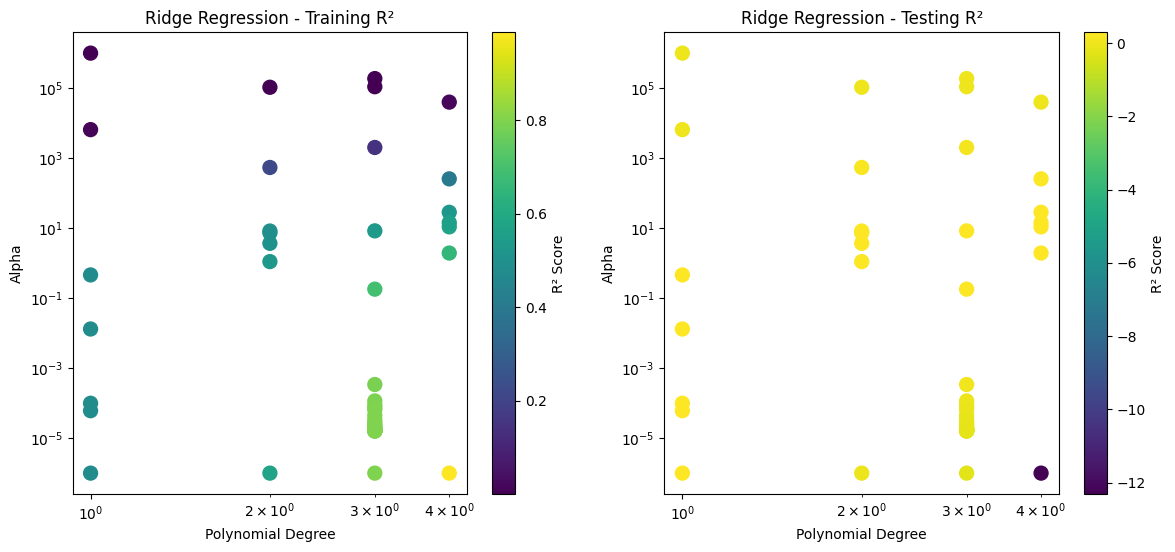

Lasso model performance: R^2 = -0.252, MSE = 0.01, RSS = 0.22
Ridge model performance: R^2 = -0.362, MSE = 0.02, RSS = 0.24


In [ ]:
#TEST MAIN


# Define X and Y
X = data_encoded.drop('out', axis=1)
Y = data_encoded['out']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the parameter space for Bayesian optimization
param_space = {
    'regressor__alpha': Real(1e-6, 1e+6, "log-uniform"),
    'poly__degree': Integer(1, 4)
}

# Function to perform Bayesian optimization and evaluation
def optimize_and_evaluate(model, X_train, Y_train, X_test, Y_test):
    pipeline = Pipeline([
        ('poly', PolynomialFeatures()),
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

    opt = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space,
        n_iter=50,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        return_train_score=True
    )

    opt.fit(X_train, Y_train)
    best_model = opt.best_estimator_

    # Calculate mean and std R² on training data
    train_r2_mean = opt.best_score_
    train_r2_std = np.std(opt.cv_results_['mean_train_score'][opt.best_index_])

    # Evaluate on test data
    test_r2 = r2_score(Y_test, best_model.predict(X_test))

    return opt, best_model, train_r2_mean, train_r2_std, test_r2

# Lasso Regression
lasso_opt, best_lasso_model, lasso_train_r2_mean, lasso_train_r2_std, lasso_test_r2 = optimize_and_evaluate(Lasso(), X_train, Y_train, X_test, Y_test)
print(f"Lasso - Best params: {lasso_opt.best_params_}, Train R² Mean: {lasso_train_r2_mean}, Train R² Std: {lasso_train_r2_std}, Test R²: {lasso_test_r2}")

# Ridge Regression
ridge_opt, best_ridge_model, ridge_train_r2_mean, ridge_train_r2_std, ridge_test_r2 = optimize_and_evaluate(Ridge(), X_train, Y_train, X_test, Y_test)
print(f"Ridge - Best params: {ridge_opt.best_params_}, Train R² Mean: {ridge_train_r2_mean}, Train R² Std: {ridge_train_r2_std}, Test R²: {ridge_test_r2}")

# Plotting the R² scores for Lasso and Ridge
def plot_r2_scores(opt, title):
    results = opt.cv_results_
    params = results['param_poly__degree']
    alphas = results['param_regressor__alpha']
    train_scores = results['mean_train_score']
    test_scores = results['mean_test_score']

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    scatter1 = ax[0].scatter(params, alphas, c=train_scores, cmap='viridis', s=100)
    ax[0].set_title(f"{title} - Training R²")
    ax[0].set_xlabel('Polynomial Degree')
    ax[0].set_ylabel('Alpha')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    fig.colorbar(scatter1, ax=ax[0], label='R² Score')

    scatter2 = ax[1].scatter(params, alphas, c=test_scores, cmap='viridis', s=100)
    ax[1].set_title(f"{title} - Testing R²")
    ax[1].set_xlabel('Polynomial Degree')
    ax[1].set_ylabel('Alpha')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    scatter2.set_clim(vmin=min(test_scores), vmax=max(test_scores))  # Ensure negative values are shown
    fig.colorbar(scatter2, ax=ax[1], label='R² Score')

    plt.show()

plot_r2_scores(lasso_opt, "Lasso Regression")
plot_r2_scores(ridge_opt, "Ridge Regression")

# Additional metrics for Lasso
Y_pred_lasso = best_lasso_model.predict(X_test)
mse_lasso = mean_squared_error(Y_test, Y_pred_lasso)
rss_lasso = np.sum((Y_test - Y_pred_lasso) ** 2)

print(f"Lasso model performance: R^2 = {lasso_test_r2:.3f}, MSE = {mse_lasso:.2f}, RSS = {rss_lasso:.2f}")

# Additional metrics for Ridge
Y_pred_ridge = best_ridge_model.predict(X_test)
mse_ridge = mean_squared_error(Y_test, Y_pred_ridge)
rss_ridge = np.sum((Y_test - Y_pred_ridge) ** 2)

print(f"Ridge model performance: R^2 = {ridge_test_r2:.3f}, MSE = {mse_ridge:.2f}, RSS = {rss_ridge:.2f}")


Given the small size of our dataset and the challenge of avoiding both overfitting and underfitting, we need to carefully select a range of models that balance complexity and regularization. The selected models should cover a spectrum from simpler to more complex, ensuring that we are well-prepared to handle the unseen data. The plot shows models and the impact of varying alpha and polynomial degrees on the training and testing R² scores. The color map indicates how different combinations affect the model's R2 score.


---
Evaluating Lasso:

Based on the Lasso regression results and analysis, here are the recommended models to try on the unseen data. A key observation is that for Lasso we can see feature selection occurring as alpha increases and as model complexity increases. We might be open to more complex models via lAsso due to this as it eliminates irrelevant features. The window for alpha quickly reduced and squeezed all the yellow dots around 0.1 and 0.001. Which becomes our window of selection.

Key Considerations:
Model Complexity: We want to explore polynomial degrees that provide enough complexity to capture the underlying patterns without overfitting.

Regularization Strength: The alpha parameter helps in regularizing the model, and we need to test a range of values to find the sweet spot within the window of good solutions.

Variance in Cross-Validation: We should select models that show good performance across different cross-validation folds, indicating robustness especially since 5 fold CV is prone to moreperformance variation.


---


Recommended LassoModels:

* Simple Model:
 Polynomial Degree: 1
 Alpha: 0.01
 Reason: This model is the simplest and helps in understanding the baseline performance with minimal complexity.

* Moderate Complexity Models:
 Polynomial Degree: 2
 Alpha: 0.001
 Alpha: 0.01
 Reason: These models offer moderate complexity with varying levels of regularization, suitable for capturing more patterns without overfitting.

* Higher Complexity Models:
 Polynomial Degree: 3
 Alpha: 0.001
 Alpha: 0.01
 Reason: These models provide higher complexity, which might be beneficial if  the unseen data has more intricate patterns.

*Highest Complexity Models:
 Polynomial Degree: 4
 Alpha: 0.0038 (Our best solution)
 Alpha: 0.01
 Reason: These models are the most complex in our selected range, with strong regularization to prevent overfitting. They performed the best in our model but ofcouurse there is a chance they overfit.



---
Evaluating Ridge:

Training R² (Left Plot):

Higher polynomial degrees with low to moderate alpha values show a mix of good and poor fits, indicating varying levels of complexity capture.
Higher alpha values generally simplify the model, reducing overfitting but potentially underfitting.
Testing R² (Right Plot):

The test R² scores are predominantly negative, indicating overfitting during training or poor generalization.
Lower degrees with moderate alpha values show relatively better test R² scores, though still not ideal.



---


Recommended Lasso Models:

Given the need to balance bias and variance with a small training dataset and the potential for a larger unseen dataset, the following model parameters are nominated for further testing:

* Degree 1, Alpha ≈ 0.1:
  Simplest model, avoiding overfitting, moderate R² scores.
* Degree 2, Alpha ≈ 1:
  Slightly more complex model, balancing bias and variance.
* Degree 3, Alpha ≈ 10:
  Captures more complexity without heavily overfitting.
* Degree 4, Alpha ≈ 0.001, 13 (our best model):
  High complexity with very minimal regularization. However our best model had an alpha of 13 so we have also nominated that.




---
Part c
This code performs the following steps to select and evaluate the best regression model for predicting the target variable:

Split Data: Splits the provided dataset into training and test sets.

Define Models: Defines a list of models to evaluate, including Lasso, Ridge, and Linear Regression, each with different polynomial degrees and alpha values.

Optimize and Evaluate Models: Uses a function to:

Create a pipeline for each model that includes polynomial feature transformation, standard scaling, and the regression model.
Fit the model on the training data and calculate the train and test R² scores.
Compute the mean squared error (MSE) on the test data.
Identify the model with the smallest generalization gap (difference between train and test R²).
Select Best Model: Finds and returns the model with the smallest generalization gap.

Evaluate Best Model on Unseen Data: Evaluates the selected best model on a new unseen dataset and computes the R² and MSE for the unseen data.

Final Evaluation Function: Provides a function to repeat the process and print the performance of the best model on the unseen data.

Overall, the code aims to select the model that generalizes best to new data by minimizing the difference between its performance on the training set and the test set, ensuring that the chosen model is neither overfitting nor underfitting.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


X = data_encoded.drop('out', axis=1)
Y = data_encoded['out']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the recommended models
recommended_models = [
    {'degree': 1, 'alpha': 0.01, 'model': 'Lasso'},
    {'degree': 2, 'alpha': 0.001, 'model': 'Lasso'},
    {'degree': 2, 'alpha': 0.01, 'model': 'Lasso'},
    {'degree': 3, 'alpha': 0.001, 'model': 'Lasso'},
    {'degree': 3, 'alpha': 0.01, 'model': 'Lasso'},
    {'degree': 4, 'alpha': 0.0038, 'model': 'Lasso'},
    {'degree': 4, 'alpha': 0.01, 'model': 'Lasso'},

    {'degree': 1, 'alpha': 0.1, 'model': 'Ridge'},
    {'degree': 2, 'alpha': 1, 'model': 'Ridge'},
    {'degree': 3, 'alpha': 10, 'model': 'Ridge'},
    {'degree': 4, 'alpha': 0.001, 'model': 'Ridge'},
    {'degree': 4, 'alpha': 13, 'model': 'Ridge'}

    #{'degree': 2, 'alpha': None, 'model': 'Linear'}
]

# Function to evaluate the model
def evaluate_model(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    train_r2 = r2_score(Y_train, Y_pred_train)
    test_r2 = r2_score(Y_test, Y_pred_test)
    mse = mean_squared_error(Y_test, Y_pred_test)
    return train_r2, test_r2, mse

# Function to find and return the best model based on the smallest generalization gap
def find_best_model(X_train, Y_train, X_test, Y_test):
    best_model_info = None
    smallest_generalization_gap = np.inf  # Initialize to a very high value

    for model_spec in recommended_models:
        degree = model_spec['degree']
        alpha = model_spec['alpha']
        model_type = model_spec['model']

        if model_type == 'Lasso':
            regressor = Lasso(alpha=alpha)
        elif model_type == 'Ridge':
            regressor = Ridge(alpha=alpha)
        elif model_type == 'Linear':
            regressor = LinearRegression()

        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree)),
            ('scaler', StandardScaler()),
            ('regressor', regressor)
        ])

        train_r2, test_r2, mse = evaluate_model(pipeline, X_train, Y_train, X_test, Y_test)
        generalization_gap = abs(train_r2 - test_r2)

        if generalization_gap < smallest_generalization_gap:
            smallest_generalization_gap = generalization_gap
            best_model_info = {
                'pipeline': pipeline,
                'model': model_type,
                'degree': degree,
                'alpha': alpha,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'mse': mse
            }

    return best_model_info

# Find the best model on the training data
best_model_info = find_best_model(X_train, Y_train, X_test, Y_test)

# Print the best model information
print("\nBest Model Information:")
print(f"Model: {best_model_info['model']}")
print(f"Degree: {best_model_info['degree']}")
print(f"Alpha: {best_model_info['alpha']}")
print(f"Train R²: {best_model_info['train_r2']}")
print(f"Test R²: {best_model_info['test_r2']}")
print(f"MSE: {best_model_info['mse']}")

# Evaluate the best model on the unseen data
def evaluate_on_unseen(best_model_info, unseen_data_path):
    unseen_data = pd.read_csv(unseen_data_path)
    X_unseen = unseen_data.drop('out', axis=1)
    Y_unseen = unseen_data['out']

    best_model = best_model_info['pipeline']
    Y_unseen_pred = best_model.predict(X_unseen)
    unseen_r2 = r2_score(Y_unseen, Y_unseen_pred)
    unseen_mse = mean_squared_error(Y_unseen, Y_unseen_pred)

    return unseen_r2, unseen_mse

# Load and evaluate on unseen data
unseen_data_path = '/content/PADL-Q2-unseen.csv'
unseen_r2, unseen_mse = evaluate_on_unseen(best_model_info, unseen_data_path)

print(f"R² on unseen data: {unseen_r2}")
print(f"MSE on unseen data: {unseen_mse}")

# Output the best model information as the final result
def final_model_evaluation():
    best_model_info = find_best_model(X_train, Y_train, X_test, Y_test)
    unseen_r2, unseen_mse = evaluate_on_unseen(best_model_info, unseen_data_path)
    print(f"Best Model: {best_model_info['model']}, Degree: {best_model_info['degree']}, Alpha: {best_model_info['alpha']}")
    print(f"R² on unseen data: {unseen_r2}")
    print(f"MSE on unseen data: {unseen_mse}")

# Call the final evaluation function
final_model_evaluation()
